In [1]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# I. Loan Default Predictive Modeling using Dask
***
*Author: Steven Glover*
*Date: 4/1/2023*
# 1) Introduction
## 1.a Problem Statement
The purpose of the project is to estimate if a member of a non-bank / finance company will default on a car loan in the next month using the Dask distributed computing framework to analyze data about member financial profile, loan characteristics, and demographics to train a predictive model.

## 1.b Description of Software Tools: Dask
Dask is a Python framework for distributed computing which enables out-of-memory and multithreading operations on a single machine or distributed processing on a cluster. Dask is written in Python and leverages popular APIs from the pydata stack for computation, such as Numpy,  Pandas and Sci-kit Learn. As a result, Dask is an appealing framework to explore if you are comfortable using the pydastack for data analysis, processing, and/or Machine learning.  If you are familiar  with Pandas then the Dask Dataframe and Dask Series objects share many syntax similarities. Likewise, numpy and sci-kit learn users, will see many parallels to the Dask array and the Dask ML APIs.  Dask works by lazily compiling a directed acyclic graph (DAG) from the processing steps defined by user. Once an object is called using action commands such as `.compute()`, `len()` , or  `head()`, Dask process the operations in parallel, making use of all cores locally or workers across a cluster. In this study, we will explore using Dask Dataframes, Dask Arrays, and the Dask ML APIs for data processing and machine learning tasks.

## 1.c Installation
It is relatively simple to create a virtual environment for Dask using coda. However, there are a couple of things that one must keep in mind when configuring the environment:
* Dask does not play well with Python 3.9+. Use python 3.8
* Likewise, certain Dask ML operations, such as ColumnTransformer, with scikit-learn dependencies will error if you use scikit-learn 1.0.0+. Scikit-learn 0.24.2 is used in this notebook.

Follow the below steps to create a virtual environment and install Dask and all other notebook dependencies:
* Create the environment: `conda create –name dask-env python-3.8`
* Activate the environment: `conda activate dask-env`
* Install Dask. Note: this will install Dask dependencies, including Numpy, Scipy, and Pandas:
   `conda install dask -c conda-forge`
* Install Dask-ML : `conda install -c conda-forge dask-ml`
* Reversion sklearn:`conda install scikit-learn=0.24.2`
* Use the `conda install` command to install the following libraries. Note: you may need to use conda-forge channel for some packages:
    - Jupyterlab
    - Matplotlib
    - Seaborn
    - python-graphviz
    - Pyarrow
    - Xgboost
    - Imbalanced-learn
    - Dask-xgboost
    - ipycytoscape

## 1.e Description of Data
The dataset was obtained from Kaggle and consists of 121,865 rows and 40 data points that describe customer attributes and loan profiles for members of a non-banking financial institution.  The below data dictionary was supplied by Kaggle and defines each data point. I augmented the supplied data dictionary to include `VariableType` and `Dtype`. The `VariableType` describes the characteristics of the variable and how it is represented, which will dictate the variable processing constraints. The `Dtype` field defines that type schema for reading the data.

The dataset can be downloaded directly from kaggle:
https://www.kaggle.com/datasets/meastanmay/nbfi-vehicle-loan-repayment-dataset?select=Test_Dataset.csv


In [2]:
data_dict = pd.read_csv("data/DataDictTypes.csv")
data_dict.head(50)

,Column,Description,VariableType,Dtype
0,ID,Client Loan application ID,ID,object
1,Client_Income,Client Income in $,Continuous,float64
2,Car_Owned,Any Car owned by client before applying for th...,Categorical (Binary),object
3,Bike_Owned,Any bike owned by client (0 means No and 1 mea...,Categorical (Binary),object
4,Active_Loan,Any other active loan at the time of aplicatio...,Categorical (Binary),object
5,House_Own,Any house owned by client (0 means No and 1 me...,Categorical (Binary),object
6,Child_Count,Number of children the client has,Discrete,float64
7,Credit_Amount,Credit amount of the loan in $,Continuous,float64
8,Loan_Annuity,Loan annuity in $,Continuous,float64
9,Accompany_Client,Who accompanied the client when client applied...,Categorical (String - Nominal),object


# II) Default Car Loans: Data Analysis and Cleaning
***
# 1. Reading the Data
## 1.a  Dask Client
To use Dask we must first create a Dask client object. By default, the client uses a local cluster. We can set the number of workers, the number of threads available per worker, and the size allocated to each worker. My machine is 16Gb. I set 4 workers each with 4GB and 1 thread.

Printing the Client object returns the details about the Dask client, cluster, and scheduler.  Clicking on the url will load dask dashboard,  which can be used for analyzing, monitoring, and debugging Dask processes.


In [3]:
# cluster = LocalCluster()
client = Client(n_workers=4,
                threads_per_worker=1,
                memory_limit='4GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64624,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:64656,Total threads: 1
Dashboard: http://127.0.0.1:64661/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:64627,


### Read data
When reading data, Dask attempts to infer the data types by taking a sample from the beginning of the file. While allowing Dask to infer the datatypes can be convenient, there is a multitude of reasons why we should explicitly define the datatypes upon reading the data.

**Numeric representation of categorical variables:** There may be binary or numeric indicators that represent categorical data or factor levels.  I would like to set all categorical data as object type, so I can easily identify qualitative fields and ensure that we are not performing any numerical computations on categorical data.

**Mixed Datatype Inference Errors:** There may be mixed datatypes in a column that could raise ValueErrors when reading the data. If there is a conflict between the data presented at the end of the file and the sample used to infer datatypes, Dask will throw an error when reading the data. For example, if we attempt to read the loans dataset without specifying the datatypes, we will receive several value errors. `Age_Days` is inferred to be a float, because it's an integer value with nulls. Since nulls are float values Dask makes the inference. However, outside the inference sample, Dask encounters a character value and throws a value error.  This inference error does occur when reading the following fields in the data:

 * Age_Days: ValueError("could not convert string to float: 'x'")
 * Client_Income: ValueError("invalid literal for int() with base 10: '32480.55'")
 * Credit_Amount: ValueError("could not convert string to float: '$'") \
 * Loan_Annuity: ValueError("could not convert string to float: '$'")
 * Population_Region_Relative: ValueError("could not convert string to float: '@'")
 * Registration_Days: ValueError("could not convert string to float: 'x'")
 * Score_Source_3: ValueError("could not convert string to float: '&'")

Another example of data type inference errors can occur when a column is populated with integer types in the inference sample but later has nulls. Since nulls are of float type, we will receive a value error.
 * ID_Days: ValueError('cannot convert float NaN to integer')
 * Employed_Days: ValueError('cannot convert float NaN to integer')

To address the above value errors, there fields will need to be read in as `object` and later cleaned.

In [4]:
dtype_dict = {
    'ID': 'object',
    'Client_Income':'object',
    'Car_Owned': 'object',
    'Bike_Owned': 'object',
    'Active_Loan': 'object',
    'House_Own': 'object',
    'Child_Count': 'float64',
    'Credit_Amount': 'object',
    'Loan_Annuity': 'object',
    'Accompany_Client': 'object',
    'Client_Income_Type': 'object',
    'Client_Education': 'object',
    'Client_Marital_Status': 'object',
    'Client_Gender': 'object',
    'Loan_Contract_Type': 'object',
    'Client_Housing_Type': 'object',
    'Population_Region_Relative': 'object',
    'Age_Days': 'object',
    'Employed_Days': 'object',
    'Registration_Days': 'object',
    'ID_Days': 'object',
    'Own_House_Age': 'float64',
    'Mobile_Tag': 'object',
    'Homephone_Tag': 'object',
    'Workphone_Working': 'object',
    'Client_Occupation': 'object',
    'Client_Family_Members': 'float64',
    'Cleint_City_Rating': 'object',
    'Application_Process_Day': 'object',
    'Application_Process_Hour': 'object',
    'Client_Permanent_Match_Tag': 'object',
    'Client_Contact_Work_Tag': 'object',
    'Type_Organization': 'object',
    'Score_Source_1': 'float64',
    'Score_Source_2': 'float64',
    'Score_Source_3': 'object',
    'Social_Circle_Default': 'float64',
    'Phone_Change': 'float64',
    'Credit_Bureau': 'float64',
    'Default':'object'
}
import dask.dataframe as dd
# Read training data
df = dd.read_csv("data/Train_Dataset.csv", dtype=dtype_dict)
# Set the id as the index. The ID is already sorted with will help with efficiency for certain operations.
df = df.set_index('ID')
df.head()

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12100001,40500,0,0,0,0,2.0,143685,4648.05,Relative,Commercial,Secondary,M,Female,CL,Home,0.007305,15678,1413,3798,4016,NaN,1,1,1,NaN,4.0,3,6,10,Yes,Yes,Business Entity Type 3,NaN,0.376053,0.493862882,0.0124,816.0,6.0,0
12100002,9900,NaN,0,1,1,2.0,29432.25,1702.35,Alone,Service,Graduation,M,Male,CL,Home,0.04622,NaN,1618,1102,2948,NaN,1,0,1,Core,4.0,1,5,16,Yes,Yes,Kindergarten,NaN,0.670373,0.513693766,0.1113,1906.0,1.0,0
12100003,49500,0,0,0,1,1.0,90000,3232.8,Alone,Commercial,Graduation,M,Male,CL,Home,0.072508,14548,7946,8689,4392,NaN,1,0,1,Accountants,3.0,1,5,18,Yes,Yes,Bank,0.62509,0.776508,0.627990819,0.4186,1711.0,4.0,0
12100004,16200,0,0,0,0,0.0,88951.5,2346.3,Alone,Service,Secondary,M,Male,CL,Home,0.008625,20060,1531,3648,3220,NaN,1,0,0,Sales,2.0,2,2,16,Yes,No,Self-employed,NaN,NaN,0.134265424,0.0309,5.0,0.0,0
12100005,8550,0,NaN,0,1,0.0,27796.95,998.1,Alone,Retired,Secondary,W,Male,CL,Home,0.018634,22977,365243,10825,NaN,NaN,1,0,1,NaN,1.0,2,5,9,Yes,Yes,XNA,NaN,0.696635,0.619527708,NaN,1985.0,5.0,0


### Partitions
Dask has read in the data as a dataframe and assigned it to only 1 partition. To take full advantage of the processing power of Dask, we should break up the data to multiple partitions. Note, each partition is a Pandas dataframe ‘under the hood.’ Setting the number of partitions can have a significant impact on Dask's performance. It is a balancing act. Too many partitions and the overhead for managing the scheduler increases. If partitions are too large, it takes more compute resources to process each chunk.  I will repartition the data to have 5 chunks.

In [5]:
print('Number of partitions created by Dask using read_csv: ', df.npartitions)
df = df.repartition(npartitions=5)
print('Number of partitions after repartitioning the data: ', df.npartitions)

Number of partitions created by Dask using read_csv:  1
Number of partitions after repartitioning the data:  5


### Setting datatypes
As discussed in section **X**  there are several non-numeric characters embedded in numeric fields, which is preventing the assignment of the correct datatype for certain variables.  For instance,  the character ‘$’ is included in the Credit_Amount field. The below function will clean non-numeric characters from the affected columns using regular expressions. In Dask we can apply the function to each partition using the  `.map_paritions()` method of the dataframe.

In [6]:
def strip_chars_from_number(dframe):
    """ Remove embedded non-numeric characters from numeric values
        and convert to float.
    """
    strip_char_cols = [
        'Client_Income',
        'Credit_Amount',
        'Loan_Annuity',
        'Population_Region_Relative',
        'Age_Days',
        'Employed_Days',
        'Registration_Days',
        'ID_Days',
        'Score_Source_3'
    ]
    for col in strip_char_cols:
        dframe[col] = dframe[col].str.extract("(\d*\.\d+|\d+)", expand=False).astype(float)
    return dframe
        
df = df.map_partitions(strip_chars_from_number)
display(df.dtypes)
df.head(20)

Client_Income                 float64
Car_Owned                      object
Bike_Owned                     object
Active_Loan                    object
House_Own                      object
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Own_House_Age                 float64
Mobile_Tag                     object
Homephone_Tag                  object
Workphone_Working              object
Client_Occupation              object
Client_Family_Members         float64
Cleint_City_

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12100001,40500.0,0,0,0,0,2.0,143685.00,4648.05,Relative,Commercial,Secondary,M,Female,CL,Home,0.007305,15678.0,1413.0,3798.0,4016.0,NaN,1,1,1,NaN,4.0,3,6,10,Yes,Yes,Business Entity Type 3,NaN,0.376053,0.493863,0.0124,816.0,6.0,0
12100002,9900.0,NaN,0,1,1,2.0,29432.25,1702.35,Alone,Service,Graduation,M,Male,CL,Home,0.046220,NaN,1618.0,1102.0,2948.0,NaN,1,0,1,Core,4.0,1,5,16,Yes,Yes,Kindergarten,NaN,0.670373,0.513694,0.1113,1906.0,1.0,0
12100003,49500.0,0,0,0,1,1.0,90000.00,3232.80,Alone,Commercial,Graduation,M,Male,CL,Home,0.072508,14548.0,7946.0,8689.0,4392.0,NaN,1,0,1,Accountants,3.0,1,5,18,Yes,Yes,Bank,0.625090,0.776508,0.627991,0.4186,1711.0,4.0,0
12100004,16200.0,0,0,0,0,0.0,88951.50,2346.30,Alone,Service,Secondary,M,Male,CL,Home,0.008625,20060.0,1531.0,3648.0,3220.0,NaN,1,0,0,Sales,2.0,2,2,16,Yes,No,Self-employed,NaN,NaN,0.134265,0.0309,5.0,0.0,0
12100005,8550.0,0,NaN,0,1,0.0,27796.95,998.10,Alone,Retired,Secondary,W,Male,CL,Home,0.018634,22977.0,365243.0,10825.0,NaN,NaN,1,0,1,NaN,1.0,2,5,9,Yes,Yes,XNA,NaN,0.696635,0.619528,NaN,1985.0,5.0,0
12100006,20250.0,1,0,0,1,0.0,52128.00,3539.25,Alone,Service,Graduation dropout,M,Female,CL,Home,0.010147,15688.0,273.0,5928.0,5313.0,64.0,1,0,0,Sales,2.0,2,3,10,Yes,Yes,Trade: type 3,0.483709,0.723729,0.621226,0.0928,708.0,1.0,0
12100007,NaN,1,0,1,1,0.0,8550.00,858.60,Partner,Retired,Secondary,M,Female,CL,Home,0.019101,24394.0,365243.0,1706.0,4613.0,6.0,1,0,1,NaN,2.0,2,3,13,Yes,Yes,XNA,NaN,0.716688,NaN,NaN,1475.0,0.0,0
12100008,6750.0,0,0,1,0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2,6,17,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
12100009,9000.0,1,0,1,0,0.0,50849.55,2446.20,Alone,Service,Secondary,M,Male,CL,Home,0.031329,18466.0,660.0,8905.0,2000.0,15.0,1,1,0,Laborers,2.0,2,2,16,Yes,Yes,NaN,NaN,0.565231,0.683269,0.2206,451.0,3.0,0


### Dask DAG
I will also take this opportunity to illustrate Dasks execution DAG to showcase how Dask processes the different components of this operation.  The `.visualize()`  dataframe method will print the DAG to the console.


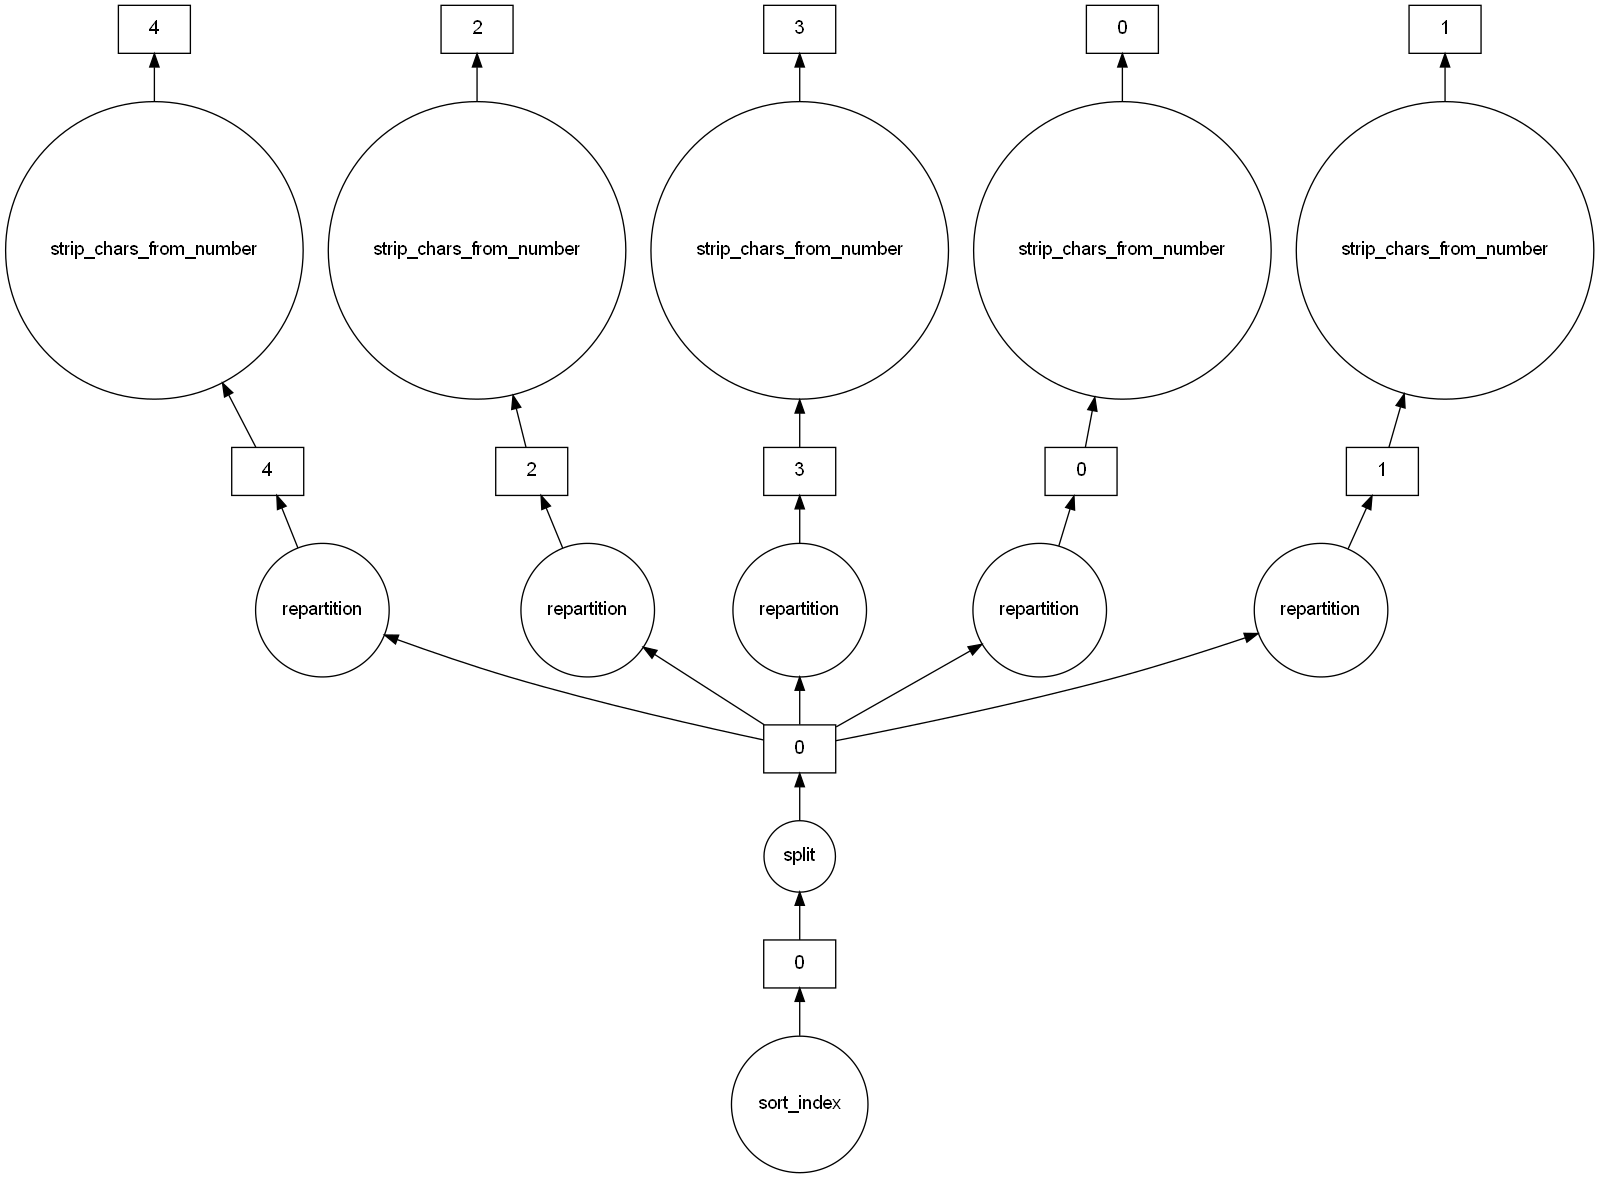

In [7]:
df.visualize(optimize_graph=True)

# Exploratory Data Analysis / Data Cleaning
## Class Distribution
There are 121,865 rows and 40 data points. The `Default` column is our target. A value of ‘1’ represents a member defaulted on their loan and ‘0’ indicates they did not. We can see from the below the classes are imbalanced. Only 8% of the members had a default. Understanding the class imbalance is important because it affects the way classifiers learn from the data and there are specific techniques that can be employed to optimize learning.  More on this later in the analysis.

Row counts:  121856


Class Distribution:


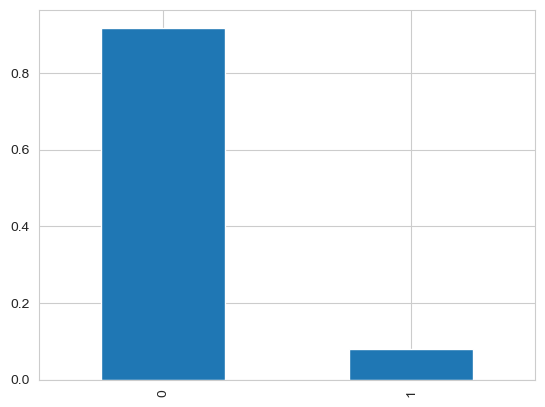

0    0.919208
1    0.080792
Name: Default, dtype: float64


0    112011
1      9845
Name: Default, dtype: int64

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

n_rows = len(df)
print("Row counts: ", n_rows)
print("\n")
print("Class Distribution:")
classes = df.Default.value_counts().compute() / n_rows
classes.plot(kind='bar')
plt.show()
print(classes)
df.Default.value_counts().compute()

## Univariate Analysis
Like the pandas API, we can use the describe function to view a summary of univariate descriptive statistics.  Reviewing the statistics early in the process can help identify potential data quality issues. We can see several possible outlier and data collection issues from reviewing the below:

**Child count:** 19 children is the max? I've never met anyone with 19 childern.
**Credit Amount:** The loans are supposed to be for car loans, yet 23 have an observation with $405,000.
**Population_Region_Relative:** The metric should be on a 0 -1 scale, but the max value is 100.
**Client Family Members:** Outlier research should be conducted
**Score_Source_2:**  Should be on a scale from 0-1. There are values of 100.
**Credit_Bureau:** Outlier Values should be inspected.
**Employed Days:** The max value of employed days is 365,243, which is 1,000 years.

In [9]:
stats = df.describe().compute()
stats

,Client_Income,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Client_Family_Members,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau
count,1.182340e+05,118218.000000,118219.000000,117030.000000,116988.000000,118239.000000,118190.000000,118225.000000,115871.000000,41761.000000,119446.000000,53021.000000,116170.000000,94934.000000,59928.000000,118192.000000,103316.000000
mean,1.686519e+04,0.417779,60046.488951,2721.254492,0.022602,16027.422948,67154.070615,4975.162123,2987.471015,12.157324,2.154329,0.501213,0.518625,0.511180,0.117428,962.106056,1.891082
std,1.153815e+04,0.728802,40350.663346,1461.466162,0.413617,4366.356504,138971.782951,3514.546963,1511.884576,12.056079,0.912686,0.211204,0.740248,0.194333,0.107974,827.976726,1.861921
min,2.565000e+03,0.000000,4500.000000,217.350000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014568,0.000005,0.000527,0.000000,0.000000,0.000000
25%,1.125000e+04,0.000000,27000.000000,1671.300000,0.010006,12432.500000,949.000000,2054.250000,1762.750000,5.000000,2.000000,0.337949,0.395650,0.377404,0.058800,282.000000,0.000000
50%,1.485000e+04,0.000000,52128.000000,2513.250000,0.018850,15770.500000,2242.000000,4538.000000,3277.000000,9.000000,2.000000,0.508002,0.569015,0.538863,0.090700,764.000000,1.000000
75%,2.025000e+04,1.000000,81000.000000,3491.100000,0.028663,19739.500000,5782.250000,7515.000000,4299.000000,15.000000,3.000000,0.676969,0.666143,0.669057,0.148500,1585.000000,3.000000
max,1.800009e+06,19.000000,405000.000000,22500.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,69.000000,16.000000,0.945741,100.000000,0.896010,1.000000,4185.000000,22.000000


## Correct / Clean Erroneous values
### Employed Days
The max value of employed days is 365,243, which is 1,000 years. There are 21,098 members effected by this data collection error, which is a significant portion of our data,  Given the research on credit, I believe `Employed_Days` will be a valuable datapoint. For my initial analysis, I will drop those observations with a 365,243 for Employed_Days. Later, I will experiment with the dropping this data point for modeling.

In [10]:
print('N values over 40 years of employment:')
display(df.loc[df.Employed_Days> 14600, 'Employed_Days'].value_counts().compute().nlargest(10))
print('N defaults for members with over 365,243 employed days')
display(df.loc[df.Employed_Days> 14600, 'Default'].value_counts().compute())
# Remove rows
df = df[df.Employed_Days < 365243]

N values over 40 years of employment:


365243.0    21098
15066.0         3
14743.0         2
15834.0         2
15422.0         2
16343.0         2
15661.0         2
14810.0         2
14801.0         2
14722.0         2
Name: Employed_Days, dtype: int64

N defaults for members with over 365,243 employed days


0    20022
1     1167
Name: Default, dtype: int64

### Population_Region_Relative:
The metric should be on a 0 -1 scale, but the max value is 100. There are 2 observations effected by this, which I will drop from the analysis.

In [11]:
print('Population_Region_Relative value errors: ', len(df[df.Population_Region_Relative > 1 ] ))
df = df[df.Population_Region_Relative <= 1 ]

Population_Region_Relative value errors:  2


### Score_Source_2
Should be on a scale from 0-1. There are 5 values of 100, which I will drop from the analysis.

In [12]:
print('Score_Source_2 value errors: ', len(df[df.Score_Source_2 > 1]))
# Drop Erroneous Values
df = df[df.Score_Source_2 <= 1]

Score_Source_2 value errors:  5


## Univariate Analysis: Visualize Categorical Variables
Let’s take a look at the member frequency of the levels for each of the categorical variables.  A Dask dataframe will return a Pandas dataframe when an action is performed on it. I will iterate over each of the categorical columns and use the pandas `.plot()` method to visualize horizontal bar plots of the data.

Categorical Visualizations
----------------------------------------------------------------


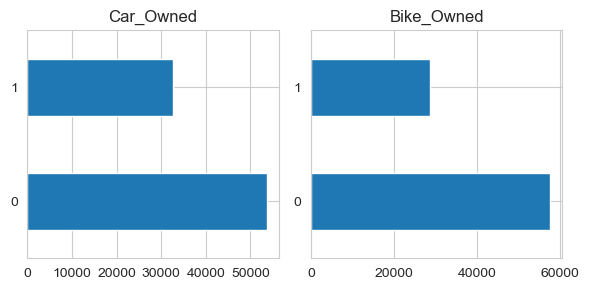

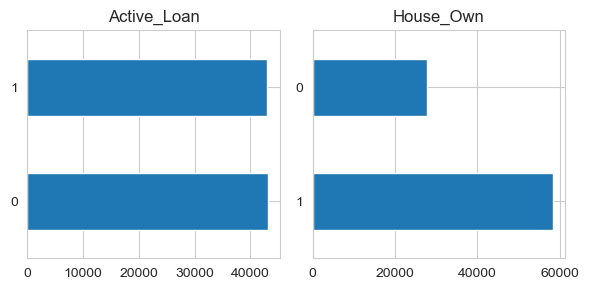

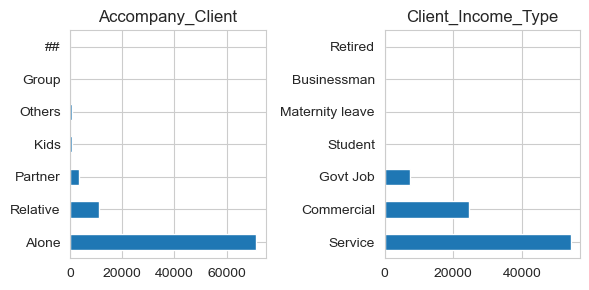

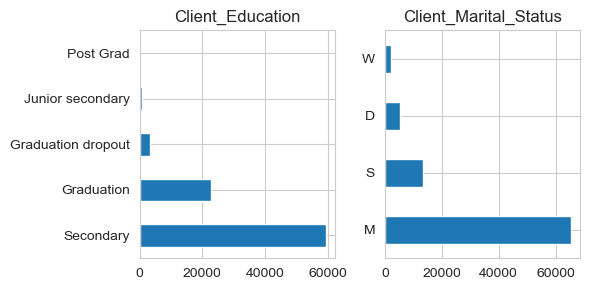

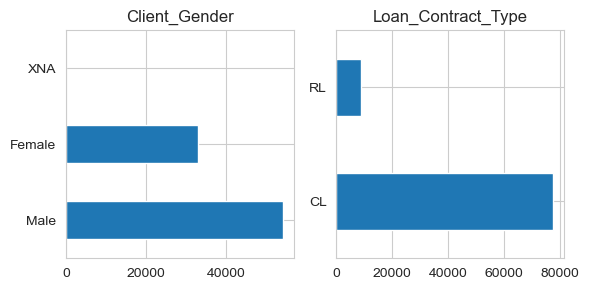

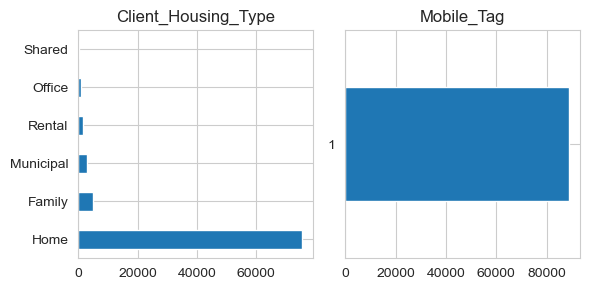

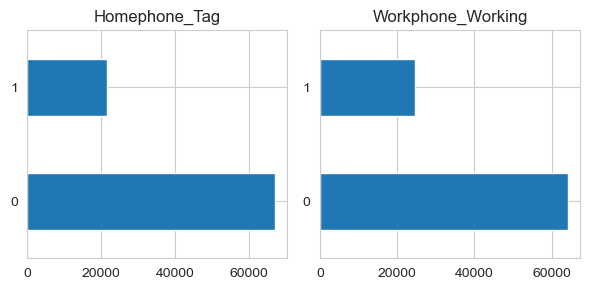

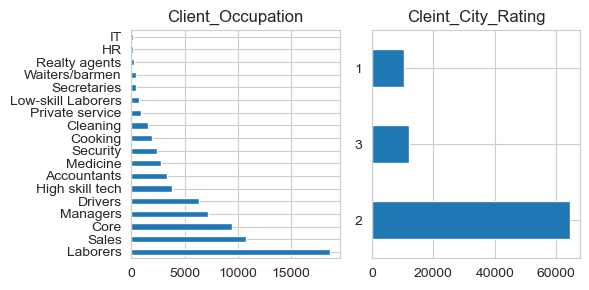

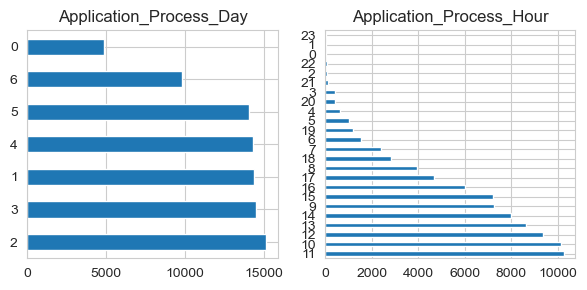

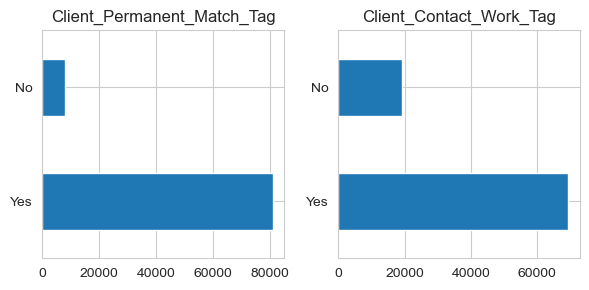

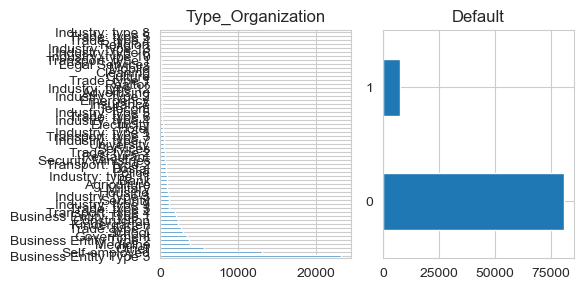

In [13]:
## Identify Categorical and numeric columns
dtypes = df.dtypes
cat_cols = dtypes[dtypes == 'object'].index.tolist()
num_cols = [col for col in df.columns if col not in cat_cols]
# Visualize the data
print('Categorical Visualizations')
print('----------------------------------------------------------------')
zipped = list(zip(cat_cols[0::2], cat_cols[1::2]))
for a,b in zipped:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    df[a].value_counts().compute().plot(kind='barh', title=a, ax=ax[0])
    df[b].value_counts().compute().plot(kind='barh', title=b, ax=ax[1])
    plt.tight_layout()
    plt.show()

### Observations Categorical Variables
I have a couple of observations after reviewing the visualizations:
1) The `Client_Gender` has 2 values of ‘XNA’, which I will remove from the analysis.
2) The `Mobile_Tag` is populated with a single value for all members: 1. I  will remove the column as it will not add any value for modelling.

In [14]:
# Clean XNA from member  gender
print("n members with gender 'XNA': ", len(df[df.Client_Gender == 'XNA']))
df = df[df.Client_Gender != 'XNA']
# Drop mobile tag variable
df = df.drop(columns=['Mobile_Tag'])

n members with gender 'XNA':  2


3) `Loan_Contract_Type` is dominated by Cash loans. However, 10% of the observations are revolving lines of credit. These are two distinct loan types, which may have very different behaviors.


In [15]:
print('Proportion of Loan Contract Type:')
display(df.Loan_Contract_Type.value_counts().compute() / len(df))

Proportion of Loan Contract Type:


CL    0.871875
RL    0.097690
Name: Loan_Contract_Type, dtype: float64

We can from the below that the Cash Loans and the Revolving Loans have different default rates 9% to 6% respectively.

In [16]:
print('Revolving Loan Default Rate')
revolve_vc = df.loc[df.Loan_Contract_Type == 'RL', 'Default'].value_counts().compute()
display(revolve_vc / revolve_vc.sum())
print('\n')
print('Cash Loan Default Rate')
cash_vc = df.loc[df.Loan_Contract_Type == 'CL', 'Default'].value_counts().compute()
display(cash_vc / cash_vc.sum())

Revolving Loan Default Rate


0    0.940526
1    0.059474
Name: Default, dtype: float64



Cash Loan Default Rate


0    0.910568
1    0.089432
Name: Default, dtype: float64

The main objective of this analysis is to identify defaulted car loans. A revolving line of credit is just that, an open line of credit that a member can continuously draw from, which by design is not a loan for a car. Additionally, we can see that the profile of these loans is different. I will keep only cash lines of credit open. Seeing that there are values over $150K, makes me question that the remaining data is all car loans. Defaulting on a car loan is a very different phenomenon from foreclosing on a home and shouldn't be modelled together.

https://www.investopedia.com/terms/r/revolvingcredit.asp

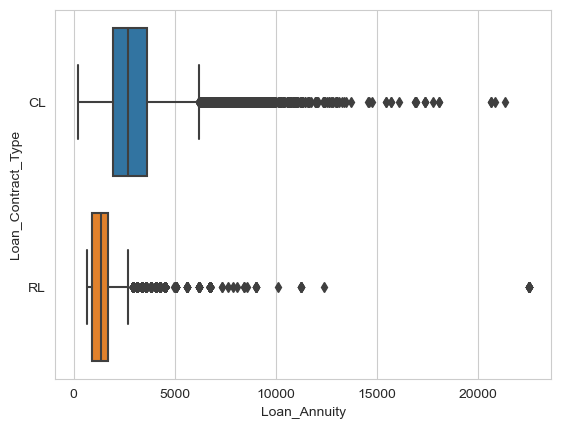

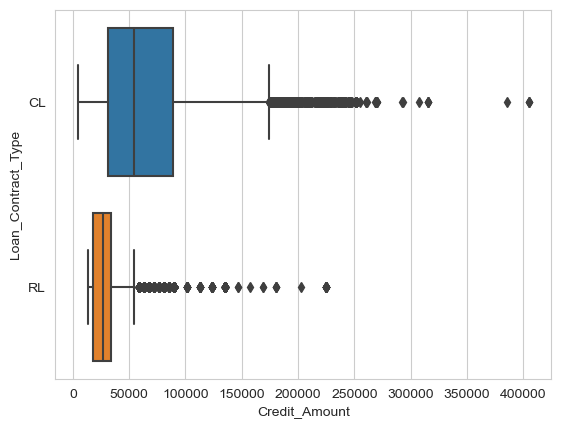

In [17]:
# Check numeric distribution for
for col in ['Loan_Annuity', 'Credit_Amount']:
    sns.boxplot(df[['Loan_Contract_Type', col]].compute(), x=col, y='Loan_Contract_Type')
    plt.show()

df = df[(df.Loan_Contract_Type == 'CL')]

4 ) The `Type_Organization` field has 57 levels. This will create a sparsity in our feature space later in the analysis. I will compress the variable by binning levels together. To accomplish this, I will rank the categorical levels by the number of defaulted observations and then compute the cumulative percentage. I will take the bin the bottom 15% of levels to ‘Other’ category, which will effectively reduce the number of levels from 57 to 16.

In [18]:
print('N type organization: ', df['Type_Organization'].nunique().compute())
# Compress multilevel factors
type_org = df.groupby(['Type_Organization', 'Default']).size().compute().rename('Data').reset_index()
type_org = type_org.pivot(index=['Type_Organization'], columns=['Default'], values=['Data'])
type_org.columns = ['No Default', 'Default']
type_org.sort_values(by='Default', ascending=False, inplace=True)
type_org['default_cum_sum'] = type_org['Default'].cumsum()
type_org['default_cum_percent'] = type_org['default_cum_sum'] / type_org['Default'].sum()
type_org

N type organization:  57


,No Default,Default,default_cum_sum,default_cum_percent
Type_Organization,,,,
Business Entity Type 3,18272.0,1952.0,1952.0,0.290563
Self-employed,10203.0,1191.0,3143.0,0.467848
Other,4506.0,385.0,3528.0,0.525156
Business Entity Type 2,2887.0,269.0,3797.0,0.565198
Construction,1808.0,255.0,4052.0,0.603156
Medicine,3137.0,253.0,4305.0,0.640816
Trade: type 7,2163.0,219.0,4524.0,0.673415
Government,2842.0,212.0,4736.0,0.704972
Transport: type 4,1435.0,179.0,4915.0,0.731617


In [19]:
### Bin the bottom 15% As Other
type_org_itemize = type_org[type_org.default_cum_percent < .85].index.tolist()
type_org_bin = type_org[type_org.default_cum_percent >=.85].index.tolist()

def bin_type_organization(x):
    """Bin Type Org"""
    if x in type_org_bin:
        return 'Other'
    else:
        return x

# Bin Types
df['Type_Organization_Bin'] = df['Type_Organization'].apply(bin_type_organization, meta=('Type_Organization', 'object'))
df = df.drop(columns= ['Type_Organization'])
df['Type_Organization_Bin'].nunique().compute()

16

# Univariate Analysis: Visualize Continuous Variables

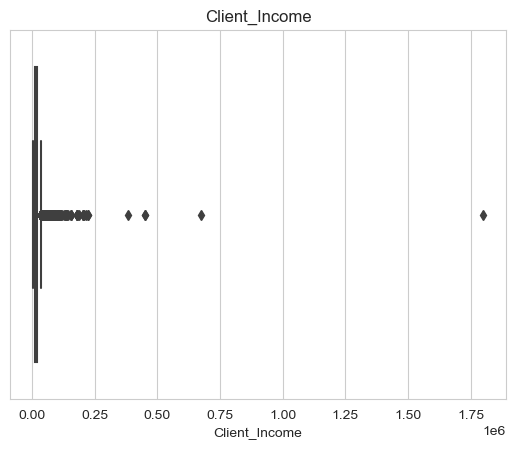

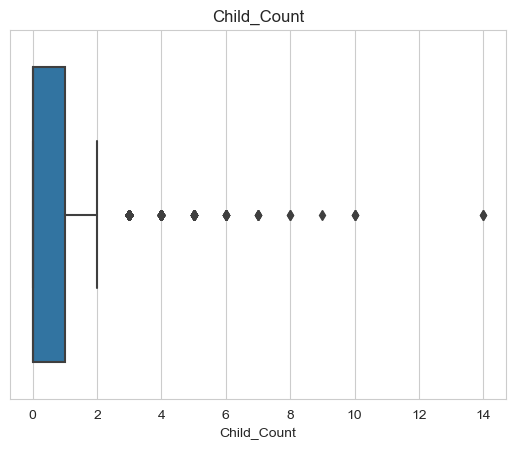

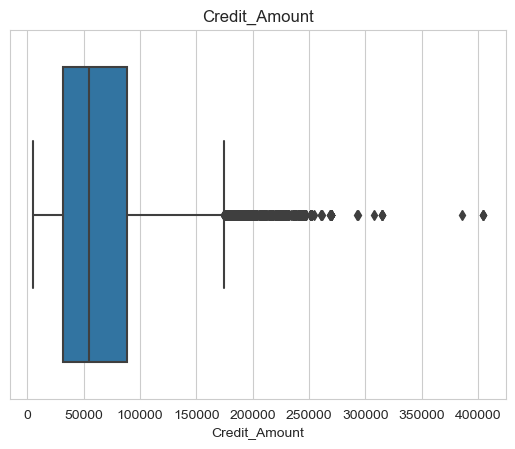

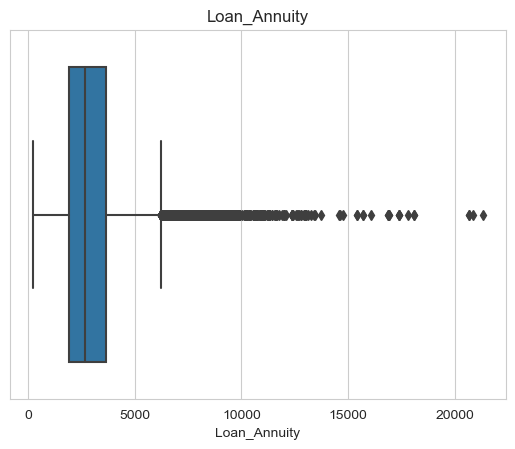

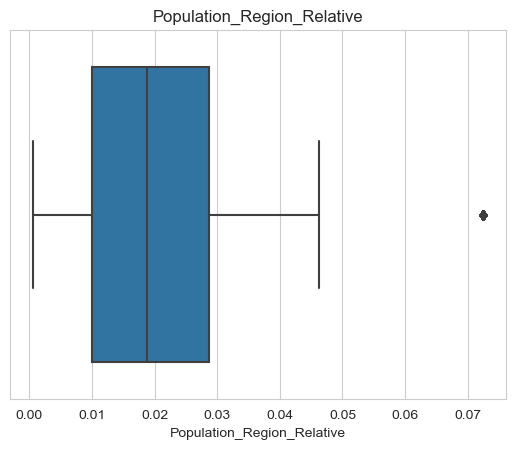

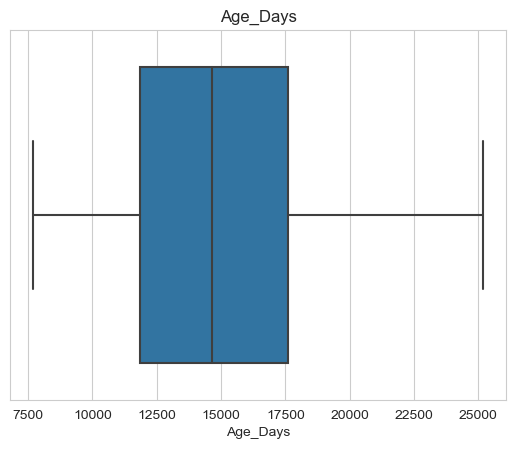

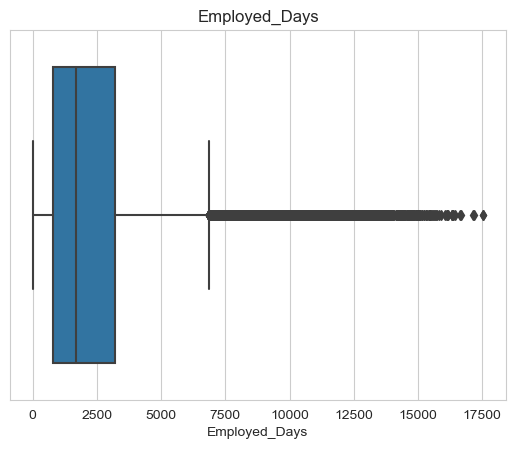

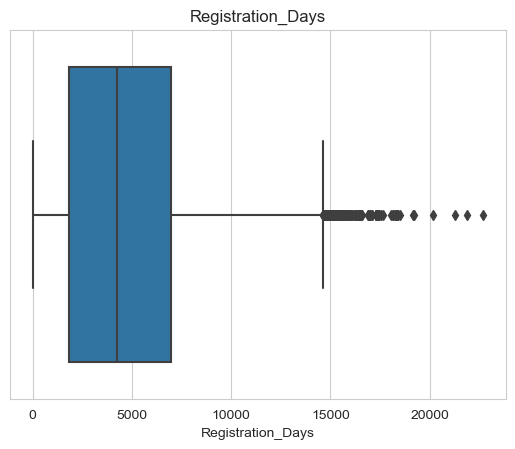

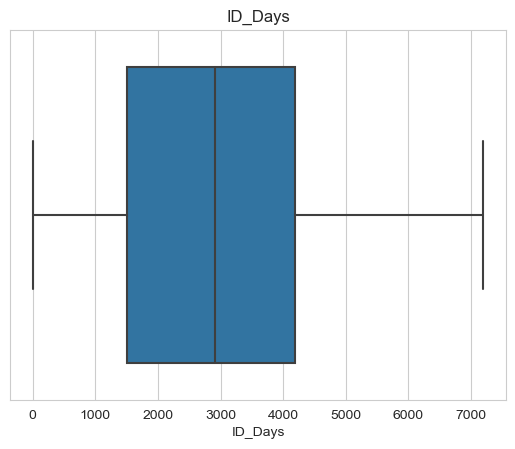

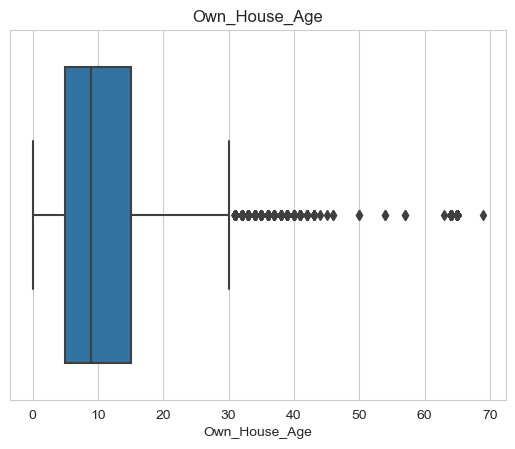

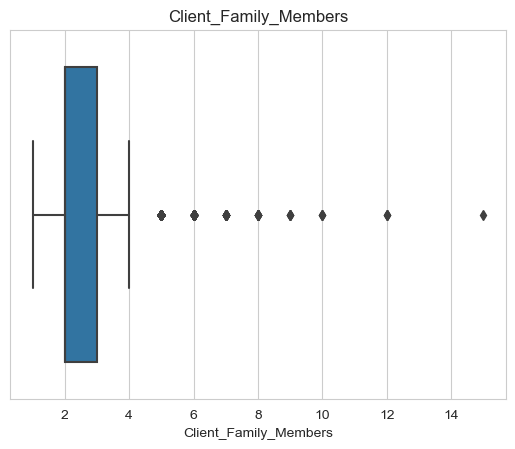

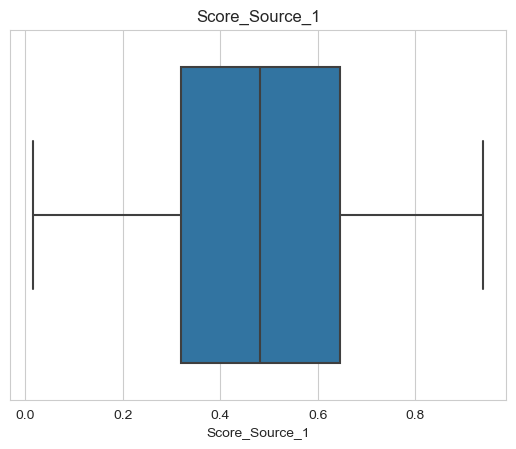

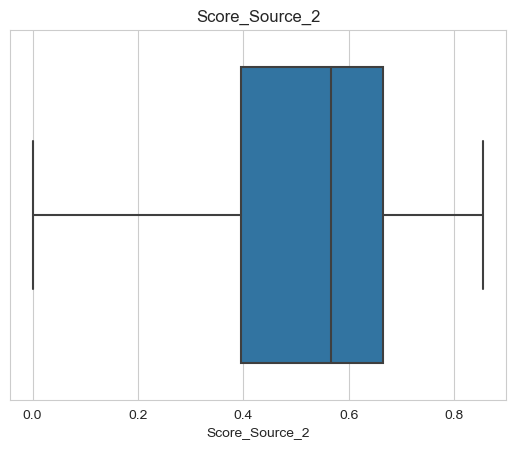

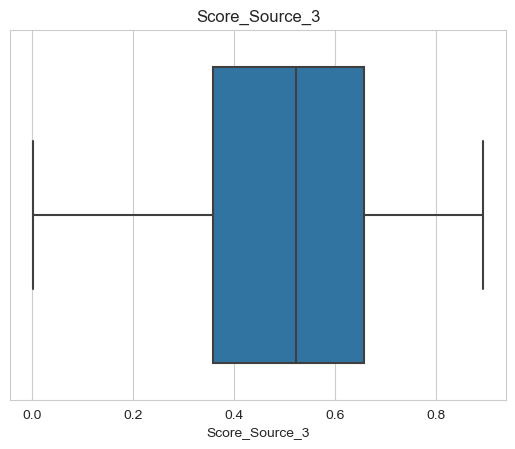

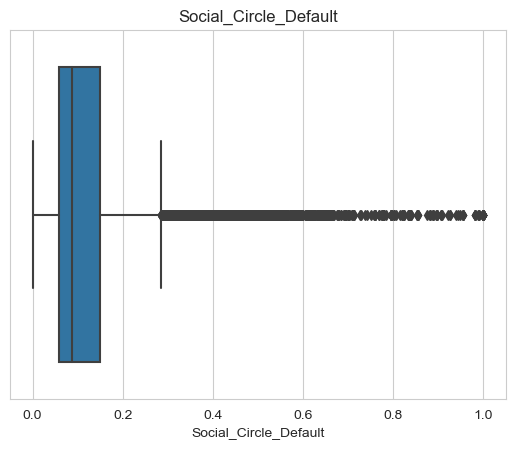

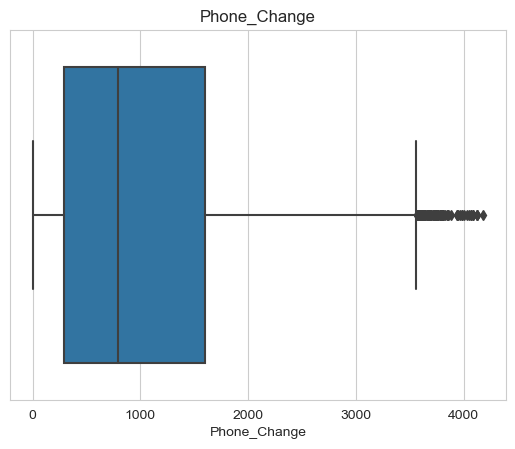

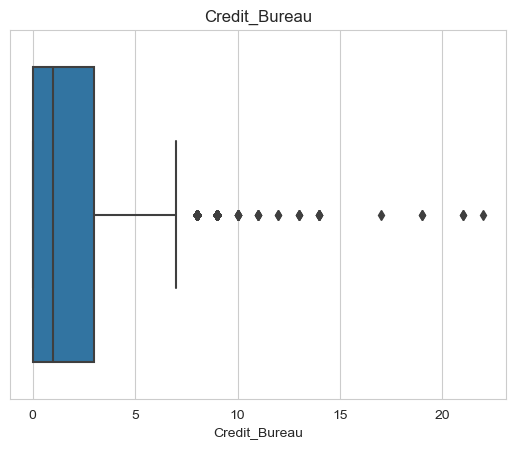

In [20]:
for col in num_cols:
    fig, ax = plt.subplots()
    sns.boxplot(df.compute(), x=col, ax=ax)
    ax.set_title(col)
    plt.show()

From reviewing the box plots we can observe that many of the variables have skewed distribution and/ or outliers, such as Client_Income, Credit_Amount, Loan_Annuity, Employed_Days, and Registration_Days. Additionally, Registration_Days and Employed_Days have some questionable values. The max Registration_Days is ~20,000, which is 54 years. The max Employed_Age is ~17,000 or 46 years. I will address these by systematically removing outliers. But first, let's address null values.

## Null Values
Many machine learning algorithms cannot learn in the presence of missing/null values in the variable. We will need to clean the missing variables from the dataset. To address the missing variables we could take several approaches:
1.	Remove the column with the missing values from the dataset. Care should be taken to ensure we are not removing a valuable signal.
2.	Remove the observations containing the missing values. Again, we should take care not to remove the valuable signal from the observations populated columns.
3.	Impute the missing values. Common approaches are to fill the missing values with the mean, median, or mode of the column
4.	Infer the missing values. Use a machine learning algorithm to infer the missing values from the other populated values.

To review the missing values, I will create a table that reports the number of missing values, the proportion of missing value, and the proportion of missing value by default.

The nulls table reports that there are 6 variables (Own_House_Age, Score_Source_1, Socal_Circle_Default, Score_Source_3) that are missing more than 10% null. Lets reivew each of these in turn to determine how we are going to treat them.

In [21]:
# Compute Nulls
nans_all = df.isnull().sum().rename('n_nulls').to_frame()
nansDefault = df[df.Default == '1'].isnull().sum().rename('n_nulls_dflt').to_frame()
nansNoDefault = df[df.Default == '0'].isnull().sum().rename('n_nulls_no_dflt').to_frame()
nulls = dd.concat([nans_all, nansDefault, nansNoDefault], axis=1)
# Compute Rows
nulls['n_rows'] = n_rows
nulls['n_rows_dflt'] = len(df[df.Default == '1'])
nulls['n_rows_no_dflt'] = len(df[df.Default == '0'])
nulls['prop_nulls'] = nulls['n_nulls'] / nulls['n_rows']
# Identify Null Proportions
nulls['prop_nulls_dflt'] = nulls['n_nulls_dflt'] / nulls['n_rows_dflt']
nulls['prop_nulls_no_dflt'] = nulls['n_nulls_no_dflt'] / nulls['n_rows_no_dflt']
nulls = nulls[['n_nulls', 'prop_nulls', 'prop_nulls_dflt', 'prop_nulls_no_dflt']]
nas = nulls.compute().sort_values(by='prop_nulls', ascending=False)
nas

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Own_House_Age,48084,0.394597,0.671047,0.616058
Score_Source_1,40427,0.331760,0.572130,0.517175
Social_Circle_Default,39627,0.325195,0.579206,0.505134
Score_Source_3,16875,0.138483,0.233502,0.216401
Client_Occupation,15226,0.124951,0.184260,0.197850
Credit_Bureau,11689,0.095925,0.179206,0.148182
ID_Days,3803,0.031209,0.048664,0.049158
Loan_Annuity,3088,0.025341,0.038412,0.040024
Client_Housing_Type,2361,0.019375,0.032635,0.030280
Application_Process_Hour,2360,0.019367,0.032058,0.030323


## Nulls Own_House_Age
There are 80K (65%) Nulls in the Own_House_Age variable. First, I would like to determine if the large quantity of null values is a function of the customer not owning their own home.  The data has binary indicators for homeowner. I counted null values for members who do not own their own homes to determine if the nulls are systematic. We can see that after removing the nulls associated with non-homeowners, there are still 56, 358 null values remaining.

In [22]:
nas.loc[['Own_House_Age'], :]

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Own_House_Age,48084,0.394597,0.671047,0.616058


Finally, I want to ensure that I am not removing any signal that may point to variation across classes for the customers with populated Own_House_Age. I created a function to display a historgram and box plot of the distribution by defaulted class. I will look at the distribution to see if data indicates variation or separation between the classes. From reviewing the below visualizations, we can see that there appears to be a systematic data collection issue at 64 months, which affects another ~1,000 customers. While there is a slight variation between the distributions, given a large number of null values and the systematic data collection issues, I will drop this data point.

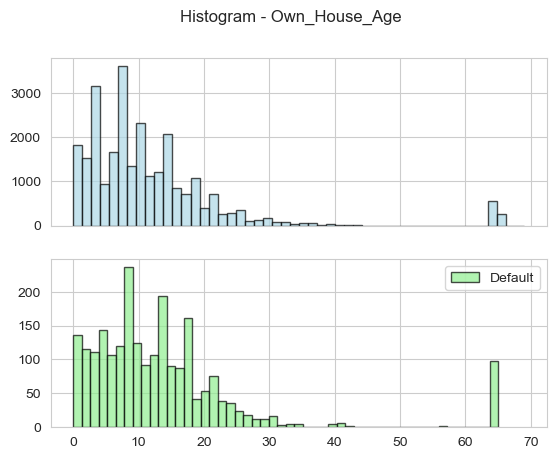

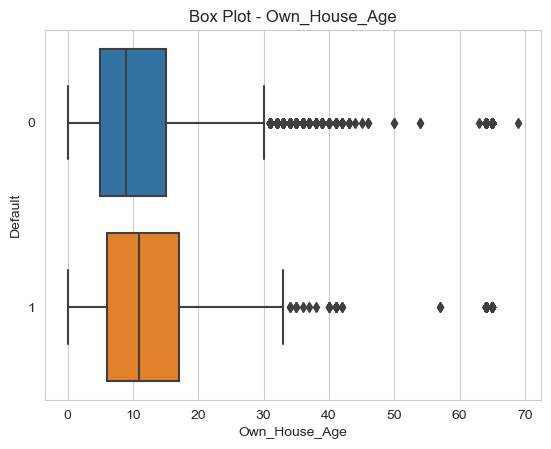

In [23]:
def plot_outcome_dist(data, column):
    """ Plot stacked histograms by outcome for specified column """
    fig, ax = plt.subplots(2, 1, sharex=True)
    fig.suptitle('Histogram - ' + column)
    ax[0].hist(
        data.loc[data.Default == '0', column].compute(),
        edgecolor='black',
        color='lightblue',
        alpha=.7,
        bins=50,
        label='NoDefault'
    )
    ax[1].hist(
        data.loc[data.Default == '1', column].compute(),
        edgecolor='black',
        color='lightgreen',
        alpha=.7,
        bins=50,
        label='Default'
    )
    plt.legend()
    plt.show()

    sns.boxplot(data[[column, 'Default']].compute(), y='Default', x=column) \
        .set_title('Box Plot - ' + column)
    plt.show()

plot_outcome_dist(df[['Own_House_Age', 'Default']], 'Own_House_Age')

## Score Source
Score_Source_1 has 56% null values. Additional Score_Source_3 has 22% null values. Intuitively, I would suspect that a member's credit score would have a strong relationship with defaulted loans. I will visualize all 3 scores side by side to understand the distributions and decide if Score_Source_1 or Score_Source_3 can be dropped without losing valuable information.

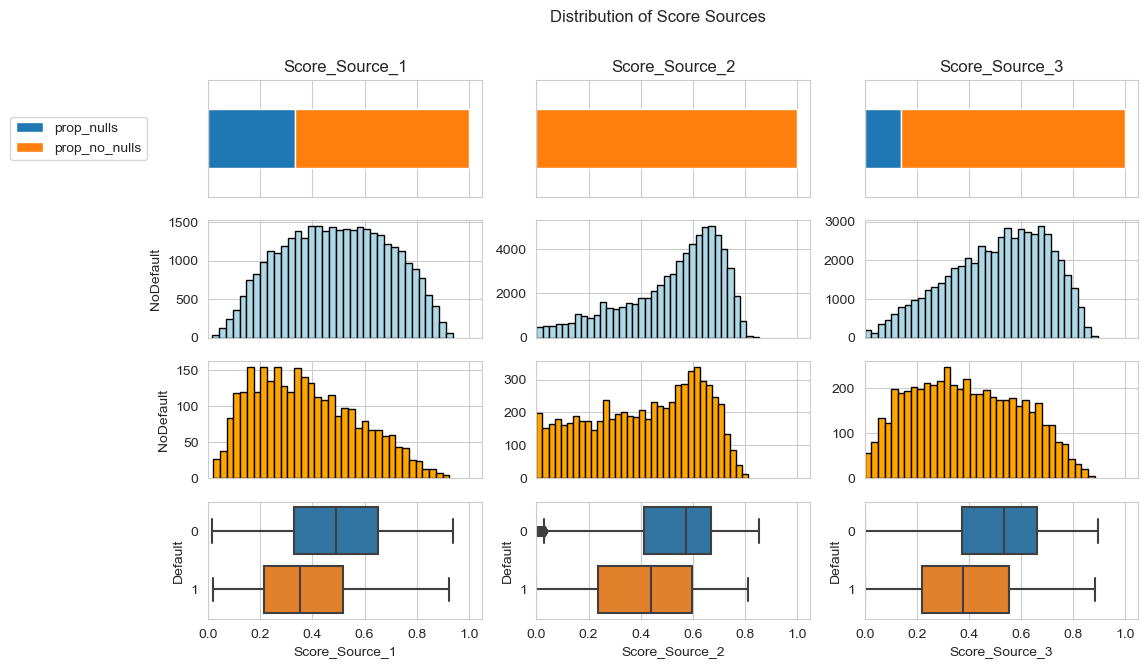

In [24]:
def plot_null_proportion(na_df, column, ax):
    """plot the proportion of nulls as horizontal"""
    plt_nulls_df = na_df.loc[column, :].to_frame().T[['prop_nulls']]
    plt_nulls_df['prop_no_nulls'] = 1 - plt_nulls_df['prop_nulls']
    plt_nulls_df.plot(kind='barh', stacked='True', ax=ax, legend=False)


col_dict = {
    0: (df, 'Score_Source_1'),
    1: (df[df.Score_Source_2 <= 1], 'Score_Source_2'),
    2: (df, 'Score_Source_3')
}

fig, ax = plt.subplots(4, 3, figsize=(12, 7), sharex=True)
fig.suptitle('Distribution of Score Sources')
for j, df_tup in col_dict.items():
    data, col = df_tup
    plot_null_proportion(nas, col, ax[0, j])
    ax[0, j].set_title(col)
    ax[0, j].set_ylabel('proportion nulls')
    ax[0, j].yaxis.set_visible(False)
    if j == 0:
        ax[0, j].legend(loc='center left', bbox_to_anchor=(-.75, 0.5), prop={'size': 10})

    ax[1 ,j].hist(
        data.loc[df.Default == '0', col].compute(),
        edgecolor='black',
        color='lightblue',
        bins=35,
        label='NoDefault'
    )
    ax[2 ,j].hist(
        data.loc[df.Default == '1', col].compute(),
        edgecolor='black',
        color='orange',
        bins=35,
        label='Default'
    )
    sns.boxplot(data[['Default', col]].compute(), y='Default', x=col, ax=ax[3, j])
    if j == 0:
        ax[1, j].set_ylabel('NoDefault')
        ax[2, j].set_ylabel('NoDefault')

plt.show()

In [25]:
df.groupby(['Default']).agg(
    {
        'Score_Source_1':['mean', 'std'],
        'Score_Source_2':['mean', 'std'],
        'Score_Source_3':['mean', 'std']
    }
).compute()

Score_Source_1           Score_Source_2           Score_Source_3  \
                  mean       std           mean       std           mean   
Default                                                                    
0             0.491021  0.203120       0.524763  0.185804       0.510548   
1             0.374942  0.197773       0.411785  0.214850       0.388504   

                   
              std  
Default            
0        0.190730  
1        0.205354

#### Dask Array API & Statistical Testing
We have seen how the syntax of a Dask data frame closely resembles that of Pandas. Dasks also have an array API that parallelizes numpy arrays. The API shares several commonly used methods supplied by numpy. I will illustrate the Dask array API by using it to take a random sample of the data in parallel and pass the sample as a numpy array to the Mann-Whitney U test Scipy function, which will determine if the means of the scores for defaulted loans are statistically different. I chose the Mann-Whiteny test over the T-test because of the strong skew of distributions.

In [ ]:
from dask.array.random import choice
from scipy.stats import mannwhitneyu

# To dask array
a_array = df.loc[(df.Default == '1') & (df.Score_Source_1.notnull()), 'Score_Source_1'].to_dask_array(lengths=True)
b_array = df.loc[(df.Default == '1') & (df.Score_Source_2.notnull()), 'Score_Source_2'].to_dask_array(lengths=True)
c_array = df.loc[(df.Default == '1') & (df.Score_Source_3.notnull()), 'Score_Source_3'].to_dask_array(lengths=True)
# Sample
a = choice(a_array, 25000).compute()
b = choice(b_array, 25000).compute()
c = choice(c_array, 25000).compute()
# Non-parm tests
source_1_2_mwu = mannwhitneyu(a, b)
source_2_3_mwu = mannwhitneyu(c, b)
# Review tests
print("Mann-Whitney U tests: ")
print("Score_Source_1 to Score_Source_2:", source_1_2_mwu)
print("Score_Source_3 to Score_Source_2:", source_2_3_mwu)

2023-05-10 13:36:06,578 - distributed.nanny - WARNING - Restarting worker
2023-05-10 13:36:06,590 - distributed.nanny - WARNING - Restarting worker
2023-05-10 13:36:06,597 - distributed.nanny - WARNING - Restarting worker


#### Score_Source Observations
We can observe, that while Score_Source_1 is over 50% null values, the distribution of the defaulted scores has the strongest right skew of the 3 reported scores indicating (as one would suspect) that lower values of Score_Source_1 may have a strong relationship with defaulted loans. We can also see a right skew in Score_Source_3 for Defaulted loans. Conversely, Score Source_2’s defaulted loan distribution has a slight left skew.  I further confirmed that the distribution of scores for members with the defaulted loan differs for Score_Source_2 and Score_Source_1 by conducting the Mann-Whitney test.

Conversely, the distribution of Score_Source_2 and Score_Source_3 for members without defaulted loans is right skewed, while the Score_Source_1 is more uniformly distributed.  Likewise, we can observe from the box plots that the average score in all 3 sources is lower for members with defaulted loans. Also,  the standard deviation for Score_Source_1 and Score_Source_3 is narrower. Score_Source_2.
All of the above indicates that there may be valuable information to be retained here. I will keep all three scores and use the values for feature engineering the following points:

* Average Score
* Min Score
* Max Score
* I will keep score_source_2 and drop Score_Source_1 and score_Source_3


## Client_Occupation
To evaluate if there are stark differences between the Cllient_Occupation across default classes, I will compute the proportion of populated values by class and review the difference. As we can see from the below, the differences are negligible. Additionally, there are 18 levels.  I will drop this variable.

In [ ]:
nas.loc[['Client_Occupation'], :]

In [ ]:
# count non-null occupation categories
occupation_n = df[df.Client_Occupation.notnull()].groupby(['Default', 'Client_Occupation']).size().rename('n_level').to_frame().reset_index()
# count non-null occupation outcomes
occupation_not_null = df[df.Client_Occupation.notnull()].groupby(['Default']).size().rename('total').to_frame()
# join levels to total
occupation_rate = occupation_n.merge(occupation_not_null, how='left', on='Default')
# get rate of n members in group to total members in outcome
occupation_rate['rate'] = occupation_rate['n_level'] / occupation_rate['total']
# Pivot rate by default - note: Dask requires column label be categorical type
occupation_rate = occupation_rate.categorize(columns=['Default']) 
occupation_pvt = occupation_rate.pivot_table(index='Client_Occupation', columns='Default', values='rate')
# difference of rates between outcomes
occupation_pvt['diff'] = occupation_pvt['1'] - occupation_pvt['0']
occupation_pvt.compute()

## Social_Circle_Default
Drop

In [ ]:
nas.loc[['Social_Circle_Default'], :]

In [ ]:
display(nas.loc[['Social_Circle_Default'],  :])
plot_outcome_dist(df[['Social_Circle_Default', 'Default']], 'Social_Circle_Default')
df.groupby(['Default']).agg({'Social_Circle_Default':['mean', 'std']}).compute()

# Credit_Bureau
Drop

In [ ]:
nas.loc[['Credit_Bureau'], :]

In [ ]:
display(nas.loc[['Credit_Bureau'],  :])
plot_outcome_dist(df[['Credit_Bureau', 'Default']], 'Credit_Bureau')
df.groupby(['Default']).agg({'Credit_Bureau':['mean', 'std']}).compute()

# Outliers
Initially, we can see that many of the distributions for numeric variables have extreme values / outlier.I will use a systematic process to clean up extreme values in the dataset before modelling. A well-accepted method for determining outliers is using 1.5 times the inner quartile range to identify outliers. I will use 3 times IQR to only remove the most extreme values.

### Detect
The below `summarize_iqr_outlier`  computes the upper boundaries of the IQR and determines how many observations are above the threshold. The function returns a list. I pass each numerical column to the function `summarize_iqr_outlier` and create a dataframe of the results, which summarizes outlier thresholds and frequency for each datapoint.


In [ ]:
import dask

def summarize_iqr_outlier(data, col):
    """ Summarizes upper bound outliers based on IQR """
    outlier_list = [col]
    q1 = data[col].quantile(.25)
    q3 = data[col].quantile(.75)
    iqr = q3 - q1
    threshold = q3 + (iqr * 3)
    outlier_list.extend(dask.compute(iqr, threshold))
    # print(iqr, threshold)
    outlier_list.append(len(data[data[col] > threshold]))
    return outlier_list

outlier_review_cols = [
    'Client_Income',
    'Child_Count',
    'Credit_Amount',
    'Loan_Annuity',
    'Client_Family_Members',
    'Phone_Change',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Population_Region_Relative'
]
outlier_review_list = []
for col in outlier_review_cols:
    outlier_review_list.append(summarize_iqr_outlier(df, col))

outlier_df = pd.DataFrame(outlier_review_list, columns=['column', 'iqr', 'threshold', 'n_outliers'])
outlier_df.set_index('column', inplace=True)
outlier_df

### Remove
Below I use the above-computed thresholds to drop the extreme values.

In [ ]:
# Extract outlier thresholds
outlier_mask = (outlier_df['n_outliers'] != 0)
rm_outliers = outlier_df.loc[outlier_mask, 'threshold'].to_dict()
print('outlier_thresholds: ', rm_outliers)

# Remove outliers
for col, thresh in rm_outliers.items():
    df = df[(df[col] <= thresh) | (df[col].isnull())]

print(f'Length of df removing outliers: {len(df)}')

####  Feature Engineering - Score_Source
In the null analysis of Score_Source_1 and Score_Source_3, we determined that there is a valuable signal to be captured. To achieve this goal, I will create new columns that capture the mean, min, max, and range of the Score_Source columns.

In [ ]:
scores_cols = [
    'Score_Source_1',
    'Score_Source_2',
    'Score_Source_3'
]

df['scores_mean'] = df[scores_cols].mean(axis=1)
df['scores_min'] = df[scores_cols].min(axis=1)
df['scores_max'] = df[scores_cols].max(axis=1)
df['scores_range'] = df['scores_max'] - df['scores_min']

df[[col for col in df.columns if 'score' in col.lower()]].head()

### Drop Columns
Drop columns to clean null values as discussed.

In [ ]:
# Drop Variables
df = df.drop(columns=['Own_House_Age', 'Client_Occupation', 'Social_Circle_Default', 'Credit_Bureau', 'Score_Source_1', 'Score_Source_3'])

# Bivariate
I will evaluate the bivariate analysis of the continuous columns using a histogram and box plot. The Score_Source variable appear to have the most separation of the distributions across classes.

In [ ]:
num_cols2 = [
    'Client_Income',
    'Child_Count',
    'Credit_Amount',
    'Loan_Annuity',
    'Population_Region_Relative',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Client_Family_Members',
    'Phone_Change',
    'Score_Source_2',
    'scores_mean',
    'scores_min',
    'scores_max',
    'scores_range'
]
for col in num_cols2:
    plot_outcome_dist(df[[col, 'Default']], col)

# Impute Missing Values
I chose to impute the mean for the numerical columns and the mode for categorical columns. If you have experience working with Sklearn, the below should look familiar. Dask-ML has clones of several popular sklearn transformers and estimators, including SimpleImputer, OneHotEncoder, MinMaxScaler, StandardScaler, ColumnTransform, GridSearchCV, etc. See the documentation. Additionally, while Dask does not have a dedicated pipeline object, we can use the sklearn pipeline object with Dask-ML components because the API sytax is designed to equivalent. Below, I demonstrate how 2 SimpleImputers (most frequent and mean) can be wrapped in a ColumnTransformer.  By specifying remainder=passthrough. All columns not operated on will pass through to the resulting Dask dataframe.

In [ ]:
from dask.ml.compose import ColumnTransformer
from dask.ml.impute import SimpleImputer

impute_mean_col = num_cols2
impute_mode_col = [col for col in df.columns if col not in impute_mean_col and col not in ['ID', 'Default']]

imputer_frequent = SimpleImputer(strategy='most_frequent')
imputer_mean = SimpleImputer(strategy='mean')
imputer_cl = ColumnTransformer(
    [
        ('most_frequent', imputer_frequent, impute_mode_col),
        ('mean', imputer_mean, impute_mean_col)
    ],
    remainder='passthrough'
)
imputer_cl.fit(df)
imputed = imputer_cl.transform(df)
imputed.head()

## Check Class Balance
Class balances remains the same after cleaning.

In [ ]:
imputed.Default.value_counts().compute() / len(imputed)

### Review and Remove Correlations
I will review the correlations between the numeric variables using a heat map of the correlation matrix. Like Pandas the Dask dataframe API has `.corr()` method.  I pass the resulting matrix to the Seaborn `.heatmap()`

In [ ]:
plt.figure(figsize=(15, 15))
correlations = imputed[num_cols2].corr().compute()
sns.heatmap(correlations, annot=True, fmt=".1f")
plt.show()

### Feature Importance
We can observe that Child_Count is highly correlated with family members. Additionally, we can see that Score_Source variables are highly correlated with one another. How can we go about removing these correlated signals from the dataset? I will determine the variable importance of using a decision tree and keep the most important variables in each group. We can use Dask to perform the all above-mentioned processing and pass the results to a scikit learn DecisionTreeClassifier As a result, I will drop score_min, score_max, and Child_Count Variables.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
y_cols = ['Default']
X_cols = [col for col in df.columns if col not in ['Default', 'ID']]

dt.fit(imputed[num_cols2].values.compute(), imputed[y_cols].values.compute().ravel())
feature_importance = pd.Series(dt.feature_importances_, index=num_cols2)
feature_importance.sort_values(ascending=False)[:30].sort_values(ascending=False).plot(kind='barh')

In [ ]:
imputed = imputed.drop(columns=['scores_min', 'scores_max', 'Child_Count'])

### Dummy Encode Categorical Features
Machine learning models require all inputs to be numeric. We must transform the categorical variables into a numerical representation that the model can understand. A very common approach to preprocessing categorical variables is to one-hot-encode them. I can use the Dask DummyEncoder to achieve this goal.  Dask requires the categorical variables to be encoded as ‘Categorical’ type before they can be passed to the DummyEncoder. I created a pipeline to process the categorical features which chains together the Dask Categorizer and DummyEncoder transformers. I wrapped the pipeline in a ColumnTransformer to allow the numeric features to passthrough, like we did when processing the SimpleImputer.

In [ ]:
# Get categorical features
imputed['Application_Process_Day'] = imputed['Application_Process_Day'].astype(int)
imputed['Application_Process_Hour'] = imputed['Application_Process_Hour'].astype(int)
dtypes = imputed.dtypes
ohe_cols = dtypes[dtypes == 'object'].index.tolist()
ohe_cols.remove('Default')
ohe_cols

In [ ]:
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler, PolynomialFeatures

ohe_pipeline = Pipeline([('categorizer', Categorizer()), ('ohe', DummyEncoder())])

categorical_preprocessing = ColumnTransformer(
    [('ohe', ohe_pipeline, ohe_cols)],
    remainder='passthrough'
)
categorical_preprocessing.fit(imputed)
categorical_encoded = categorical_preprocessing.transform(imputed)
categorical_encoded.head()

### Checkpoint
#### Save parquet

#### Read parquet

In [ ]:
categorical_encoded_rd = dd.read_parquet('data/categorical_encode', engine="pyarrow", calculate_divisions=True)

### Feature Interactions
Interactions between variables may exist and could potentially be meaningful predictors. Dask has a PolynomialFeatures() class that can be used to create interaction features, which I used below. Again, I wrapped the in a column transformer to allow the original feature set to pass through.

In [ ]:
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler, PolynomialFeatures
from dask_ml.compose import ColumnTransformer

# Change default to int type
categorical_encoded_rd['Default'] = categorical_encoded_rd['Default'].astype(int)

# Define numeric columns
numeric_cols = [
    'Application_Process_Day',
    'Application_Process_Hour',
    'Client_Income',
    'Credit_Amount',
    'Loan_Annuity',
    'Population_Region_Relative',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Client_Family_Members',
    'Phone_Change',
    'Score_Source_2',
    'scores_mean',
    'scores_range'
]
# Create interactions
poly_feat = PolynomialFeatures(interaction_only=True, preserve_dataframe=True)
interaction_transformer = ColumnTransformer(
    [('interaction', poly_feat, [col for col in categorical_encoded_rd.columns if col != 'Default'])],
    remainder='passthrough'
)
interaction_transformer.fit(categorical_encoded_rd)
interactions = interaction_transformer.transform(categorical_encoded_rd)

### Remove null variance interactions
When creating interactions using the one-hot-encoded dataframe, interactions are created from all categorical columns, which will result in many in zero variance columns.  For example, the interaction between gender-male and gender-female will always be zero. The sklearn Variance threshold has not been cloned in Dask yet. I will perform that action manually, using the nunqiue() method to identify the columns that have only 1 unique value and remove them.

In [ ]:
interactions = interactions.repartition(npartitions=50)
interactions.columns = [col.replace(' ', '-') for col in interactions.columns]

In [ ]:
# interactions.columns = [col.replace(' ', '-') for col in interactions.columns]
nunique = interactions.nunique().compute()
zero_var_col = nunique[nunique == 1].index.tolist()
interactions = interactions.drop(columns=zero_var_col)
print('# of zero variance columns: ', len(zero_var_col))
print('# of columns retained: ', len(interactions.columns))

In [ ]:
# interactions.to_parquet('data/interactions', engine="pyarrow", write_index=True, write_metadata_file=True)
interactions = dd.read_parquet('data/interactions', engine="pyarrow", calculate_divisions=True)

# Train / Test Split
Dask does have a sklearn train_test_split() clone. However, the Dask clone does not support stratified splitting operations. Since we have an imbalanced class, I want to ensure that class imbalance remains consistent across the train, validation, and test datasets. I perform the split manually below.

https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.sample.html

In [ ]:
import dask.dataframe as dd

interactions['split_col']  = interactions.index.values

# Subset neg pos class
neg_class = interactions[interactions.Default == 0].copy()
pos_class = interactions[interactions.Default == 1].copy()

# Sample 80% for train and take the remainder for test
# Note:  dask.array<invert> not supported error thrown when attempting to subset on index. Duplicated the index as a column to work around.
neg_class_train = neg_class.sample(frac=.8, replace=False, random_state=0)
neg_class_validate = neg_class[~neg_class.split_col.isin(neg_class_train.split_col.unique().compute())].copy()
pos_class_train = pos_class.sample(frac=.8, replace=False, random_state=0)
pos_class_validate = pos_class[~pos_class.split_col.isin(pos_class_train.split_col.unique().compute().tolist())].copy()

# Concatenate Positive and Negative Class
train_subset = dd.concat([neg_class_train, pos_class_train])
validate_subset = dd.concat([neg_class_validate, pos_class_validate])

# Neg Class Sample Validation
neg_class_rows = len(neg_class)
neg_class_train_rows = len(neg_class_train)
neg_class_validate_rows = len(neg_class_validate)
pos_class_rows = len(pos_class)
pos_class_train_rows = len(pos_class_train)
pos_class_validate_rows = len(pos_class_validate)

print('Negative Class Sample Validation')
print('---------------------------------------------------------')
print('neg class rows: ' , neg_class_rows)
print('neg class train: ', neg_class_train_rows)
print('neg class test: ', neg_class_validate_rows)
print('Test neg_class data (diff): ', neg_class_rows - neg_class_train_rows - neg_class_validate_rows)
print('\n')
print('Positive Class Sample Validation')
print('---------------------------------------------------------')
print('pos class rows: ' , pos_class_rows)
print('pos class train: ', pos_class_train_rows)
print('pos class test: ', pos_class_validate_rows)
print('Test neg_class data (diff): ', pos_class_rows - pos_class_train_rows - pos_class_validate_rows)
print('\n')
print("Train / Test Rows Validation")
print('---------------------------------------------------------')
print('train validation: ', len(train_subset) - pos_class_train_rows - neg_class_train_rows)
print('test set validation: ', len(validate_subset) - pos_class_validate_rows - neg_class_validate_rows)
print('train balance: ')
display(train_subset.Default.value_counts().compute()/ len(train_subset))
print('train balance: ')
display(validate_subset.Default.value_counts().compute() / len(validate_subset))

### Scaling the numeric variables.
The training for many ml models can be optimized by transforming the numeric variables to be the same scale. A common method for scaling variables is StandardScaling, which subtracts the mean and divides by the standard deviation. Dask has the StandardScaler() transformer to perform this operation. I need to identify all numeric columns including interactions.  I created the `match_col` function to identify the numeric interaction column using the original numeric column labels.


In [ ]:
numeric_cols = [
    'Application_Process_Day',
    'Application_Process_Hour',
    'Client_Income',
    'Credit_Amount',
    'Loan_Annuity',
    'Population_Region_Relative',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Client_Family_Members',
    'Phone_Change',
    'Score_Source_2',
    'scores_mean',
    'scores_range'
]
def match_col(x):
    return [col for col in interactions.columns if x in col]

scale_columns = []
for col in numeric_cols:
    scale_columns.extend(match_col(col))

scale_columns = list(set(scale_columns))

I can pass these columns to the StandardScaler() to transform the variables.

In [ ]:
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.preprocessing import Categorizer, DummyEncoder

preprocessing = ColumnTransformer([('scaler', StandardScaler(), scale_columns),],
    remainder='passthrough'
)
preprocessing.fit(train_subset)
train = preprocessing.transform(train_subset)
validate = preprocessing.transform(validate_subset)
train.head()

### Split X and y

In [ ]:
X_train = train.drop(columns=['Default', 'split_col'])
y_train = train[['Default']]
X_validate = validate.drop(columns=['Default', 'split_col'])
y_validate = validate[['Default']]

# Check point
***
## Write to Parquet

In [ ]:
X_train = X_train.repartition(npartitions=10)
y_train = y_train.repartition(npartitions=10)
X_validate = X_validate.repartition(npartitions=10)
y_validate = y_validate.repartition(npartitions=10)
train_subset = train_subset.repartition(npartitions=10)
validate_subset = validate_subset.repartition(npartitions=10)

## Read Parquet

# Machine Learning
To illustrate how Dask can be used for Machine Learning I will perform Supervised and unsupervised tasks. First, we will cluster the data and visualize the clusters using Principle Components Analysis. Next, we will move to supervised techniques for classification, where we will explore different techniques used in Dask for fitting models and cross-validation.

## Unsupervised Learning - Clustering
### Choosing K
We can use the k-means clustering algorithm to identify patterns in the data. Kmeans uses distance measures to find groups within the data that are most similar to the group yet different from the other groups. Because kmeans uses distance measures, we can only pass numeric features to the algorithm. Kmeans requires that we define how many groups cluster. One way of determining the number of groups is to use a technique commonly referred to as the ‘elbo’ plot where we plot the inertia of clusters at each value of k.  The point at which the inertia delta has a noticeable decrease will determine the number of clusters, which in the below plot is k=3.

**Note:** Dask does have an implementation of the kmeans algorithm. However, I found the implementation to return results that were inconsistent with my previous experience clustering. For example, the elbow plot typically has decreasing inertia. Visualizing the elbow plot for using the Dask API I found the inertia to vary wildly. As a result, I used the sklearn kmeans implementation.

.

In [ ]:
#from dask_ml.cluster import KMeans
from sklearn.cluster import KMeans
import joblib
# dask.config.set(scheduler='threads') # Try this if it fails again.
cluster_cols = [
    'Client_Income',
    'Credit_Amount',
    'Population_Region_Relative',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Client_Family_Members',
    'Phone_Change',
    'scores_mean',
]

ks = range(1, 8)
inertias = []
for k in ks:
    # with joblib.parallel_backend('dask'):
    model = KMeans(n_clusters=k)
    model.fit(X_train[numeric_cols].compute())
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Fit Kmeans
Below I fit the kmeans using k=3 and saved the model object to disk for future use using pickle serialization.

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(X_train[numeric_cols].compute())

In [ ]:
import pickle
pickle.dump(km, open('models/kmeans.pkl', 'wb'))

### PCA to Visualize Clusters
It can be helpful to visualize the clusters. A common approach is to use Principle Component Analysis (PCA) to reduce the dimensionality of the feature space to 2 dimensions and clusters on the components.  Dask has a PCA class that can be used to achieve this goal. The API is essentially identical to that of the scikit learn API.

In [ ]:
from dask_ml.decomposition import PCA
pca_viz = PCA(n_components=2)
pca_viz.fit(X_train[cluster_cols].to_dask_array(lengths=True))
pcs_viz = pca_viz.transform(X_train[cluster_cols].to_dask_array(lengths=True))

#### Plot PCs and Clusters

In [ ]:
pcs_df = dd.from_dask_array(pcs_viz, columns=['pc1', 'pc2']).compute()
pcs_df['clusters'] = km.labels_
pcs_df['default'] = y_train['Default'].values.compute()

# pcs = pcs.compute()
fig, ax = plt.subplots()
for cluster in sorted(pcs_df.clusters.unique()):
    mask = (pcs_df.clusters == cluster)
    ax.scatter(
        pcs_df.loc[mask, 'pc1'],
        pcs_df.loc[mask, 'pc2'],
        label='Cluster - ' + str(cluster),
        marker='.',
        alpha=.4,
        s=.5
    )
ax.set_title('PC - Clusters')
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [40]
lgnd.legend_handles[1]._sizes = [40]
lgnd.legend_handles[2]._sizes = [40]
plt.show()

### Distribution of Default Across Clusters
I created a cross tab of the cluster and default and augmented the cross tab with the proportion of default in the cluster and the proportion of all defaults captured in each cluster.  Interestingly we see that 62% of all defaults are captured in cluster 0 and cluster 0 has a default rate of 15% while being of similar size to cluster 1. Cluster 1 has a default rate of 5% as does Cluster 2. Cluster 0 is a comparatively high default group with a rate of default that is 10% higher than the two.


In [ ]:
cluster_default = y_train.Default.to_frame().compute()
cluster_default['Cluster'] = km.labels_
cluster_ct = pd.crosstab(cluster_default.Default, cluster_default.Cluster).T
cluster_ct['cluster_total'] = cluster_ct.sum(axis=1)
cluster_ct['prop_default_in_cluster'] = cluster_ct[1] / cluster_ct['cluster_total']
cluster_ct['prop_default_in_all'] = cluster_ct[1] / cluster_ct[1].sum()
cluster_ct

### Cluster Profiling
Following the clustering we compare the distributions of the input variables to profile the clusters. What makes cluster 0 different from the others? Cluster 0 distributions are in a noticeably lower domain for the following variables:
* Age days
* Employed Days
* Registration Days
* Phone change
* A significant difference in the mean scores.


In [ ]:
import seaborn as sns

cluster_profiles = train_subset[cluster_cols].compute()
cluster_profiles['cluster'] = km.labels_
cluster_profiles['cluster'] = cluster_profiles['cluster'].astype(str)

for col in cluster_cols:
    fig, ax = plt.subplots()
    sns.boxplot(data=cluster_profiles[[col, 'cluster']], x=col, y='cluster', ax=ax)
    ax.set_title(col + ' Cluster Distribution')
    plt.show()

del cluster_profiles

# Supervised Learning – Classification
Below we build several models, illustrating different ways we leverage Dask for classification tasks. The first way we use Dask, is to assign the joblib library parallel backend to use the Dask scheduler.  Using this technique enables us to leverage Dask in concert with scikit learn estimators and other estimator APIs that use the sklearn sytax such as imbalanced-learn. The imbalanced learn API has some great tools for the classification for imbalanced datasets.

In [ ]:
import numpy
import joblib
from dask_ml.model_selection import GridSearchCV as daskGridSearch
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Base Model: Random Forest
To start we will multithread the scikit learn RandomForest classifier with Dask using joblib. For the benchmark model,  I will use the default parameters without any hyperparameter tuning.  I used the feature importance to identify the top 25 performing features and refit the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
import joblib

# Train a random forest using all features
rf = RandomForestClassifier(n_jobs=-1)
with joblib.parallel_backend('dask'):
    rf.fit(X_train.values.compute(), y_train.values.compute().ravel())

# Select the top 25 features
rf_feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_feature_importances.sort_values(ascending=False).sort_values(ascending=False)
select_features = rf_feature_importances[:25].index.tolist()

# Fit benchmark model using the top 25 features
rf = RandomForestClassifier(n_jobs=-1)
with joblib.parallel_backend('dask'):
    rf.fit(X_train[select_features].values.compute(), y_train.values.compute().ravel())

### Custom Model Logging
I built custom logging classes to track performance across model experiments. The ModelLog class creates objects for evaluating various classification metrics for a model including Accuracy, Precision, Recall, F1 score, Kappa, and ROC Area Under the Curve. Additionally, the ModelLog also produces visualizations of the confusion matrix, ROC curve, and thePrecision–Recall curve. Finally, the class produces a table that evaluates classification metrics at different positive prediction thresholds to provide a resource to tune the threshold.

The ExpreimentLog object function is to store all the ModelLogs. The class will enable us to retrieve all previous run experiments and provides a method for comparing performance via a metric table.


In [ ]:
class ModelLog:
    """ Log classification and metrics and evaluation curves"""
    def __init__(self, model, X, y, label):
        self.model = model
        self.y_pred = model.predict(X)
        self.y_score = model.predict_proba(X)
        self.y_true = y
        self.label = label
        self.metrics = self.get_metrics()

    def get_metrics(self):
        """ compute classification metrics """
        metrics = {
            'accuracy':  accuracy_score(self.y_true, self.y_pred),
            'precision': precision_score(self.y_true, self.y_pred),
            'recall': recall_score(self.y_true, self.y_pred),
            'f1': f1_score(self.y_true, self.y_pred),
            'kappa': cohen_kappa_score(self.y_true, self.y_pred),
            'roc': roc_auc_score(self.y_true, self.y_score[:, 1])
        }
        return pd.DataFrame(metrics, index=[self.label]).T

    def print_classification_report(self):
        """print sklearn classification report"""
        print(classification_report(self.y_true, self.y_pred))

    def print_confusion_matrix(self):
        """ print confusion matrix heat map"""
        matrix_df = pd.DataFrame(confusion_matrix(self.y_true, self.y_pred), index=[0, 1], columns=[0, 1])
        sns.heatmap(matrix_df, annot=True, cmap='Blues', fmt='g')
        plt.show()

    def plot_curves(self):
        """Plot precision and recall curves"""
        ### ROC Curve
        y_true = y_validate.compute()
        # ROC Curve Data
        null_probs = [0 for _ in range(len(self.y_pred))]
        null_fpr, null_tpr, _ = roc_curve(self.y_true, null_probs)
        model_fpr, model_tpr, _ = roc_curve(self.y_true, self.y_score[:, 1])
        # Precision - Recall Data
        no_skill = len(self.y_true[self.y_true['Default'] == 1]) / len(self.y_true)
        precision, recall, _ = precision_recall_curve(y_true, self.y_score[:, 1])
        # Plot ROC
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        ax1.set_title('ROC Curve')
        ax1.plot(null_fpr, null_tpr, linestyle='--', color='grey')
        ax1.plot(model_fpr, model_tpr,  color='lightblue', label=f'ROC AUC {round(roc_auc_score(self.y_true, self.y_score[:, 1]),3)}')
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.legend()
        # Plot Precision-Recall Curve
        ax2.set_title('Precision- Recall Curve')
        ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax2.plot(recall, precision)
        ax2.set_xlabel('recall')
        ax2.set_ylabel('precision')
        ax2.legend()
        plt.show()

    def assess_prediction_threshold(self):
        """ Evaluate classification metrics at thresholds """
        thresholds = list(np.arange(.05, 1, .05))
        threshold_df = pd.DataFrame()
        # Evaluate scores at each cutoff threshold
        for i, thresh in enumerate(thresholds):
            probs = self.y_score[:, 1]
            y_pred = np.where(probs > thresh, 1, 0)
            cm = confusion_matrix(self.y_true, y_pred)
            row = pd.DataFrame(
                {
                    'threshold': thresh,
                    'TP': cm[1, 1],
                    'TN': cm[0, 0],
                    'FP': cm[0, 1],
                    'FN': cm[1, 0],
                    'Accuracy': accuracy_score(self.y_true, y_pred),
                    'Precision': precision_score(self.y_true, y_pred),
                    'Recall': recall_score(self.y_true, y_pred),
                    'f1': f1_score(self.y_true, y_pred),
                    'Kappa': cohen_kappa_score(self.y_true, y_pred)
                },
                index=[i]
            )
            threshold_df = pd.concat([threshold_df, row], axis=0)
        return threshold_df

    def print_report(self):
        print(self.metrics)
        print('\n')
        self.print_classification_report()
        self.print_confusion_matrix()
        self.plot_curves()

    def __repr__(self):
        return str(self.label)

class ExperimentLog:
    """Log to record experiments"""
    def __init__(self):
        self.model = {}

    def record_experiment(self, model_log):
        """ Log experiment to dictionary """
        self.model[model_log.label] = model_log

    def compare_models(self):
        metric_list = []
        for key, value in self.model:
            metric_list.append(value.metrics)
        return pd.concat(metric_list)

### Log Benchmark Model
The base model captured 15.4% of all defaults and did so with a precision of 87%. This a very precise model with a low false positive rate but it does not detect a large proportion of the defaults.  We can also see from reviewing the precision-recall curve that there is a drastic cost in precision if we were to decrease the .5 prediction threshold to capture more of the target. There are other algorithms and methods we can experiment with in an attempt to capture a larger proportion of defaulted loans.

In [ ]:
# Create experiment log
log = ExperimentLog()
# Create model log for random forest
rf_report = ModelLog(
    model=rf,
    X=X_validate[select_features].compute(),
    y=y_validate.compute(),
    label='RandomForest-Baseline'
)
#log experiment
log.record_experiment(rf_report)
log.model['RandomForest-Baseline'].print_report()

# Balanced Random Forest
One of the ways we can address the class imbalance problem is with sampling. Oversampling and undersampling are often employed in an attempt to balance the classes. The imbalanced-learn API has a modified random forest classifier called the `BalancedRandomForestClassifier.` The algorithm performs in much of the same way as the random forest with one exception, it undersamples the majority class for each sample. The balance of the classes is controlled using the sampling_strategy parameter. Undersampling, while it can help to capture more of the positive class it often comes at a cost of precision and an increased false rate.  To illustrate this behaviour, I will plot the cross-validated precision and recall for sampling strategies 10%, 20%, 30%, 40%, and 50%.  Again, I’m using the joblib parallel_backend to pass the multithreading to Dask.


In [ ]:
import numpy
from dask_ml.model_selection import GridSearchCV as daskGridSearch
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

recalls = []
precisions = []
y_true = y_validate.values.compute().ravel()
for i in [.1,.2, .3, .4, .5]:
    brf = BalancedRandomForestClassifier(random_state=0, n_estimators=100, sampling_strategy=i,n_jobs=-1)
    # Fit using dask as a back-end
    with joblib.parallel_backend('dask'):
        cv = StratifiedKFold(n_splits=3)
        cv_recall = cross_val_score(
           brf,
           X_train[select_features].values.compute(),
           y_train.values.compute().ravel(),
           scoring='recall',
           cv=cv,
           n_jobs=-1
        )
        cv_precision = cross_val_score(
           brf,
           X_train[select_features].values.compute(),
           y_train.values.compute().ravel(),
           scoring='precision',
           cv=cv,
           n_jobs=-1
        )
        recalls.append(np.mean(cv_recall))
        precisions.append(np.mean(cv_precision))

The visualization illustrates that as the sampling strategy increases we can capture more of the positive class but it comes with a large decrease in the precision of the model. I like any model produced here to have a precision of at least .5. According to the above plot, at a sampling strategy of .2 we are estimated to capture around 18% of the target.

In [ ]:
fig, ax = plt.subplots()
ax.plot([.1, .2, .3, .4, .5], recalls, label='recall')
ax.plot([.1, .2, .3, .4, .5], precisions, label='precision')
ax.set_xlabel('sampling_strategy')
ax.set_title('Sampling Strategy Effect on Classification Metrics')
ax.legend()
plt.show()

## Dask Grid Search: Cross-Validation
Dask has GridSearchCV, which gives us the ability to tune models through models using cross-validation.  Below I tune the max depth parameter of the BalancedRandomForestClassifier for values of 12, 14, 16, and 18. We will choose the best model based on the cohen_kappa_score, which is appropriate for imbalanced classes. The GridSeachCV doesn’t natively support the kappa metric, but we can create the scorer using the sklearn.metrics function `make_scorer`. Additionally, Dask gives us the ability to use sklearn StratifiedKFold object, which ensures the class balance of each KFold is evenly distributed.

In [ ]:
from dask_ml.model_selection import GridSearchCV as daskGridSearch
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

kappa_scorer = make_scorer(cohen_kappa_score)

param_grid = {
    'n_estimators': [500],
    'max_depth': [12, 14, 16, 18],
}
brf = BalancedRandomForestClassifier(random_state=0, criterion='gini', sampling_strategy=.25)
cv = StratifiedKFold(n_splits=3)
brfcv = daskGridSearch(estimator=brf, param_grid=param_grid, cv= cv, scoring=kappa_scorer, n_jobs=-1)
brfcv.fit(X_train[select_features].values, y_train.values)

print("Best Score: ", brfcv.best_score_)
print("Best params: ", brfcv.best_params_)

In [ ]:
brf_report = ModelLog(
    model=brfcv,
    X=X_validate[select_features].compute(),
    y=y_validate.compute(),
    label='Balanced-Random-Forest-All'
)
#log experiment
log.record_experiment(brf_report)
log.model['Balanced-Random-Forest-All'].print_report()

# XGBoost
Dask has an xgboost classifier. However, I was unable to get it to run without error. Additionally, I attempted to distribute the training of the xgboost classifier using the dask joblib backend, which also did not run successfully. For comparison purposes, I will train the data using xgboost package. I tune the following parameters:
•	Scale_pos_weight: This parameter adjusts the weights to account for the imbalanced class
•	Max_dept: how many partitions in each tree
•	Learning_rate: adjust the rate at which the algorithm makes the adjustment to the learned weights.

https://examples.dask.org/machine-learning/xgboost.html
https://towardsdatascience.com/parallel-xgboost-with-dask-in-python-11f7ed004dd3

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    eval_metric='error',
    early_stopping_rounds=100,
    scale_pos_weight=7,
    learning_rate = .1,
    max_depth=16
    #class_weight={0: 1, 1: 10}
)
xgb_model.fit(X_train[select_features], y_train, eval_set=[(X_validate[select_features], y_validate)])
y_pred = xgb_model.predict(X_validate[select_features])
accuracy_score(y_validate.compute(), y_pred)

In [ ]:
log = ExperimentLog()
xgb_report = ModelLog(
    model=xgb_model,
    X=X_validate[select_features].compute(),
    y=y_validate.compute(),
    label='XGB-All'
)
#log experiment
log.record_experiment(xgb_report)
log.model['XGB-All'].print_report()

In [ ]:
log.model['XGB-All'].assess_prediction_threshold()

## Summary
There appears to be an overwhelming signal in the data which is enabling us to capture a small proportion of the defaulted loans with high precision. This classifier would be valuable to the business to identify loans that are of high risk of defaulting. However, efforts should be made to model the other 88% of defaulted loans.

## Next Steps
 There are strategies we can employ to capture a larger proportion of the loans. The first thing we can explore is gathering additional data points from the business about the customers and their loan attributes, such as how much of the loan is outstanding, how many missed payments the customer has had in the past, the time since loan origination, the interest rate, car type, etc. In the absence of additional data, we could explore modeling segments of the population independently. We saw that over 62% of all defaulted loans fell into a single cluster. Modeling clusters separately could enable the algorithm to pick up different signals in each and capture more of  the response. Finally, there are many different modeling approaches that could be employed that may add lift in the metrics such as deep learning (Dask also integrates with Keras).

## Thoughts on Dask
The Dask framework for distributed computing integrates well with the existing pydata stack: Numpy, Pandas, Sklearn, Xgboost, and Matplotlib for scientific computing,  data manipulation, statistics, and machine learning.  While the documentation states the installation is straightforward using pip or conda, I found that it has version dependencies in supporting libraries cause certain operations to fail if not configured properly. Because Dask is designed to distribute Numpy arrays, and Pandas dataframes, and integrate with Scikit-learn, users familiar with these APIs can get up and running quickly with this framework as their syntax was constructed to be equivalent in many places. Dask does allow for out-of-memory computations on a local cluster, however, I found the performance can suffer with large DAG operations. Dask has many tools in its ML toolkit that can be used for distributing learning tasks. There were some ML functionality that I expected Dask-ML to support that was unavailable or don’t perform as I expected:

* Stratified Train-Test split not available. Required for imbalanced classification problems.
* Some transformers are not available or supported such as Normalizer, FeatureUnion, etc.
* Dask implementation of the Kmeans algorithm did not perform as expected
* Dask implementation of XGBoost errored in my environment, but I was able to pass Dask objects to the XGBoost API

Dask is a great tool for distributed processing in Python. I think Dask ML has a lot of room to grow as a ML framework.

